In [1]:
# Process GCMs (Graph Centrality Measures) on dbpedia data 

# Installing packages
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install networkx
#!pip install rdflib
#!pip install mlnotify

# Importing packages
import pandas as pd
#from SPARQLWrapper import SPARQLWrapper, JSON, N3
#import lxml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx import Graph as NXGraph
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import statistics
import collections

#import danker # https://github.com/athalhammer/danker
from scipy import stats
from urllib import parse

from sklearn import linear_model

import mlnotify 
# https://github.com/aporia-ai/mlnotify
# Use %%notify at beginning of cell

import os.path, time
# Use %%time at beginning of cell

print('------------')
!python --version
print("Pandas " + pd.__version__)
print("Numpy " + np.__version__)
#print('Matplotlib {}'.format(matplotlib.__version__))
print("Seaborn " + sns.__version__)
print("Networkx " + nx.__version__)
print('------------')
print("All packages loaded and ready to roll :-)")

------------
Python 3.7.6
Pandas 1.3.4
Numpy 1.18.1
Seaborn 0.11.2
Networkx 2.4
------------
All packages loaded and ready to roll :-)


In [2]:
#load GCM data

#df_pr = pd.read_csv("../keseitz/data/PageRank/df_pr.csv")
#df_pr.head()

df_gcm = pd.read_csv("../data/gcm_computed.nosync/gcm-metrics1.csv")
df_gcm.head()

,resource,degree,pagerank
0,http://dbpedia.org/resource/Boss_(rapper),1.334412e-06,5.202821e-08
1,http://dbpedia.org/resource/Def_Jam_Recordings,1.265265e-04,8.024377e-06
2,http://dbpedia.org/resource/Great_Mazinger,1.091792e-06,3.370992e-07
3,http://dbpedia.org/resource/Masayuki_Akechi,1.213102e-07,2.965359e-08
4,http://dbpedia.org/resource/Rafael_Trujillo__T...,4.852407e-07,5.954646e-08


In [3]:
# (OLD) Method for splitting the resource to get resource/name (based of the URI) to match PageRank dataframe

def node_path (row):
    return parse.urlsplit(row['resource']).path.split('/', 1)[-1]

In [4]:
#pr_total = df_pr['pagerank'].sum()
pr_total = df_gcm['pagerank'].sum()
print("PageRank normalized probability distribution:")
print (pr_total)
# -> Normalverteilung um 1 rum (Durchschnitt ist 1 wie es bei PageRank sein sollte -> test auf Normalverteilung

PageRank normalized probability distribution:
1.0000000000005405


In [5]:
print(8243333*7.805755e-08)

0.64345437781415


In [6]:
# Test on normality distribution

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
stats.normaltest(df_gcm['pagerank'])

NormaltestResult(statistic=68373823.03822671, pvalue=0.0)

In [13]:
from scipy.stats import kstest
# https://www.statology.org/normality-test-python/

print("Normal distribution for PageRank")
print('======================')
print(stats.normaltest(df_gcm['pagerank']))

print(kstest(df_gcm['pagerank'], 'norm'), '[Kolmogorov-Smirnov-Test]') # Kolmogorov-Smirnov-Test for normality

Normal distribution for PageRank
NormaltestResult(statistic=68373823.03822671, pvalue=0.0)
KstestResult(statistic=0.5000000072594243, pvalue=0.0) [Kolmogorov-Smirnov-Test]


In [10]:
from scipy.stats import kstest
# https://www.statology.org/normality-test-python/

kstest(df_gcm['pagerank'], 'norm') # Kolmogorov-Smirnov-Test for normality -> Daten nicht normalverteilt da <0.5

KstestResult(statistic=0.5000000072594243, pvalue=0.0)

In [12]:
print("Normal distribution for Degree Centrality")
print('======================')
print(stats.normaltest(df_gcm['degree']))

print(kstest(df_gcm['degree'], 'norm'), '[Kolmogorov-Smirnov-Test]') # Kolmogorov-Smirnov-Test for normality

Normal distribution for Degree Centrality
NormaltestResult(statistic=69557965.55953461, pvalue=0.0)
KstestResult(statistic=0.5000000483957555, pvalue=0.0) Kolmogorov-Smirnov-Test


## Get DBpedia categories

In [3]:
%%time

# Alternative load presaved (via queried web-interface) DBpedia

# 90s films from the aggregated Categories: 1990_films, 1991_films, 1992_films, ...
df_film90 = pd.read_csv("../data/sparql_cat_queries/sparql_90film.csv")
df_film90.rename(columns={"90film": "resource"}, inplace=True) #rename column to match PageRank dataframe
#df_film90['resource'] = df_film90.apply(lambda row: node_path(row), axis=1) #split resource to get resource/name (based on URI) to match PageRank dataframe


# actors from the "Occupation": "Actor"@en
df_actor = pd.read_csv("../data/sparql_cat_queries/sparql_actor.csv")
df_actor.rename(columns={"actor": "resource"}, inplace=True)
#df_actor['resource'] = df_actor.apply(lambda row: node_path(row), axis=1)


# Music Genre from the "Type": "dbo:MusicGenre"
df_musicGenre = pd.read_csv("../data/sparql_cat_queries/sparql_musicGenre.csv")
df_musicGenre.rename(columns={"mGenre": "resource"}, inplace=True)
#df_musicGenre['resource'] = df_musicGenre.apply(lambda row: node_path(row), axis=1)


# Books from the "Type":"dbo:book"
df_book = pd.read_csv("../data/sparql_cat_queries/sparql_book.csv")
df_book.rename(columns={"book": "resource"}, inplace=True)
#df_book['resource'] = df_book.apply(lambda row: node_path(row), axis=1)


# Book authors from the "Type": author UNION book dbo:author
df_bookAut = pd.read_csv("../data/sparql_cat_queries/sparql_bookAuthor.csv")
df_bookAut.rename(columns={"author": "resource"}, inplace=True)
#df_bookAut['resource'] = df_bookAut.apply(lambda row: node_path(row), axis=1)


# Politicians from the "Type": Person/Politician
df_pol = pd.read_csv("../data/sparql_cat_queries/sparql_politician.csv")
df_pol.rename(columns={"pol": "resource"}, inplace=True)
#df_pol['resource'] = df_pol.apply(lambda row: node_path(row), axis=1)


# POTUS from the "Category": Presidents_of_the_United_States
df_potus = pd.read_csv("../data/sparql_cat_queries/sparql_potus.csv")
df_potus.rename(columns={"potus": "resource"}, inplace=True)
#df_potus['resource'] = df_potus.apply(lambda row: node_path(row), axis=1)


# Cities from the "Category": "dbo:City"
df_city = pd.read_csv("../data/sparql_cat_queries/sparql_city.csv")
df_city.rename(columns={"city": "resource"}, inplace=True)
#df_city['resource'] = df_city.apply(lambda row: node_path(row), axis=1)


# Lakes from the "Category": "dbo:Lake"
df_lake = pd.read_csv("../data/sparql_cat_queries/sparql_lake.csv")
df_lake.rename(columns={"lake": "resource"}, inplace=True)
#df_lake['resource'] = df_lake.apply(lambda row: node_path(row), axis=1)


# Mountains from the "Category": "dbo:Mountain"
df_mountain = pd.read_csv("../data/sparql_cat_queries/sparql_mountain.csv")
df_mountain.rename(columns={"mount": "resource"}, inplace=True)
#df_mountain['resource'] = df_mountain.apply(lambda row: node_path(row), axis=1)


# EU capitals from the "Category": Capitals_in_Europe
df_euCap = pd.read_csv("../data/sparql_cat_queries/sparql_euCap.csv")
df_euCap.rename(columns={"euCap": "resource"}, inplace=True)
#df_euCap['resource'] = df_euCap.apply(lambda row: node_path(row), axis=1)


# EU countries from the "Category": Countries_in_Europe
df_euCou = pd.read_csv("../data/sparql_cat_queries/sparql_euCountry.csv")
df_euCou.rename(columns={"euCountry": "resource"}, inplace=True)
#df_euCou['resource'] = df_euCou.apply(lambda row: node_path(row), axis=1)


# Asian countries from the "Category": "dbc:Countries_in_Asia", "dbc:East_Asian_countries" and "dbc:Central_Asian_countries"
df_asCou = pd.read_csv("../data/sparql_cat_queries/sparql_asCountry.csv")
df_asCou.rename(columns={"asCountry": "resource"}, inplace=True)
#df_asCou['resource'] = df_asCou.apply(lambda row: node_path(row), axis=1)


# Continents from the "Category": "dbo:Continents"
df_continent = pd.read_csv("../data/sparql_cat_queries/sparql_continent.csv")
df_continent.rename(columns={"conti": "resource"}, inplace=True)
#df_continent['resource'] = df_continent.apply(lambda row: node_path(row), axis=1)


# Birds from the "Class": "dbr:Bird"
df_bird = pd.read_csv("../data/sparql_cat_queries/sparql_bird.csv")
df_bird.rename(columns={"bird": "resource"}, inplace=True)
#df_bird['resource'] = df_bird.apply(lambda row: node_path(row), axis=1)


# African animals from the "Category": "dbc:Vertebrates_of_Africa"
df_africanAnimal = pd.read_csv("../data/sparql_cat_queries/sparql_africanAnimal.csv")
df_africanAnimal.rename(columns={"afrAnimal": "resource"}, inplace=True)
#df_africanAnimal['resource'] = df_africanAnimal.apply(lambda row: node_path(row), axis=1)


# Furniture from the "Category": "dbc:Furniture"
df_furniture = pd.read_csv("../data/sparql_cat_queries/sparql_furniture.csv")
df_furniture.rename(columns={"fur": "resource"}, inplace=True)
#df_furniture['resource'] = df_furniture.apply(lambda row: node_path(row), axis=1)


# Furniture from the "Category": "dbc:Vegetables"
df_vegetable = pd.read_csv("../data/sparql_cat_queries/sparql_vegetable.csv")
df_vegetable.rename(columns={"veg": "resource"}, inplace=True)
#df_vegetable['resource'] = df_vegetable.apply(lambda row: node_path(row), axis=1)


# Types of fast food from the "Category": "dbc:Fast_food"
df_fastFood = pd.read_csv("../data/sparql_cat_queries/sparql_fastfood.csv")
df_fastFood.rename(columns={"fastFood": "resource"}, inplace=True)
#df_fastFood['resource'] = df_fastFood.apply(lambda row: node_path(row), axis=1)


# European Landmark/Sight from multiple "Category": "dbc:Landmarks_in_x" with x being a country from europe
df_euSight = pd.read_csv("../data/sparql_cat_queries/sparql_euLandmark.csv")
df_euSight.rename(columns={"euroSight": "resource"}, inplace=True)
#df_euSight['resource'] = df_euSight.apply(lambda row: node_path(row), axis=1)


# DAX company from the "Type": "dbo:Company" and "dbp:tradedAs" -> "dbr:DAX"
df_daxCo = pd.read_csv("../data/sparql_cat_queries/sparql_daxCompany.csv")
df_daxCo.rename(columns={"DAXco": "resource"}, inplace=True)
#df_daxCo['resource'] = df_daxCo.apply(lambda row: node_path(row), axis=1)


# US company from ?
df_usCo = pd.read_csv("../data/sparql_cat_queries/sparql_usCompany.csv")
df_usCo.rename(columns={"USCo": "resource"}, inplace=True)
#df_usCo['resource'] = df_usCo.apply(lambda row: node_path(row), axis=1)


# US tech company from the "Category": "dbc:Technology_companies_of_the_United_States"
df_usTechCo = pd.read_csv("../data/sparql_cat_queries/sparql_usTechCompany.csv")
df_usTechCo.rename(columns={"usTech": "resource"}, inplace=True)
#df_usTechCo['resource'] = df_usTechCo.apply(lambda row: node_path(row), axis=1)

CPU times: user 264 ms, sys: 93.7 ms, total: 358 ms
Wall time: 528 ms


### EU capital

In [4]:
# EU capitals

# Merge the DFs based on resource with an Left Merge / Left Outer Join
# (Keep every row in the left dataframe. Missing values get NaN)

euCap_result = pd.merge(df_euCap,
                 #df_pr[['resource_id','resource', 'pagerank']],
                 df_gcm[['resource','degree','pagerank']],
                 on='resource', 
                 how='left')

#euCap_result['resource'] = euCap_result.apply(lambda row: node_path(row), axis=1)
euCap_result = euCap_result.drop(0) # custom for EU capitals as value with index 0 is a faulty entry

euCap_result

,resource,name,degree,pagerank
1,http://dbpedia.org/resource/Podgorica,Podgorica,6.004853e-05,6.215473e-06
2,http://dbpedia.org/resource/City_of_San_Marino,City of San Marino,1.140316e-05,1.392710e-06
3,http://dbpedia.org/resource/Kyiv,Kyiv,2.552366e-04,3.266771e-05
4,http://dbpedia.org/resource/Amsterdam,Amsterdam,3.773959e-04,5.877084e-05
5,http://dbpedia.org/resource/Athens,Athens,2.847150e-04,3.651685e-05
6,http://dbpedia.org/resource/Berlin,Berlin,6.037607e-04,8.670599e-05
7,http://dbpedia.org/resource/Copenhagen,Copenhagen,4.168217e-04,7.165694e-05
8,http://dbpedia.org/resource/Dublin,Dublin,6.200163e-04,8.493329e-05
9,http://dbpedia.org/resource/Helsinki,Helsinki,2.807117e-04,4.386219e-05
10,http://dbpedia.org/resource/Lisbon,Lisbon,2.523252e-04,3.448612e-05


In [233]:
# Test normal distribution
stats.normaltest(euCap_result['pagerank'])

NormaltestResult(statistic=57.7625461797501, pvalue=2.8643261421028853e-13)

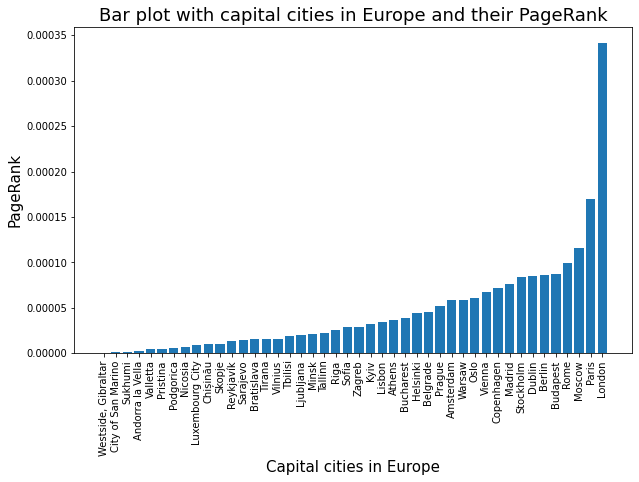

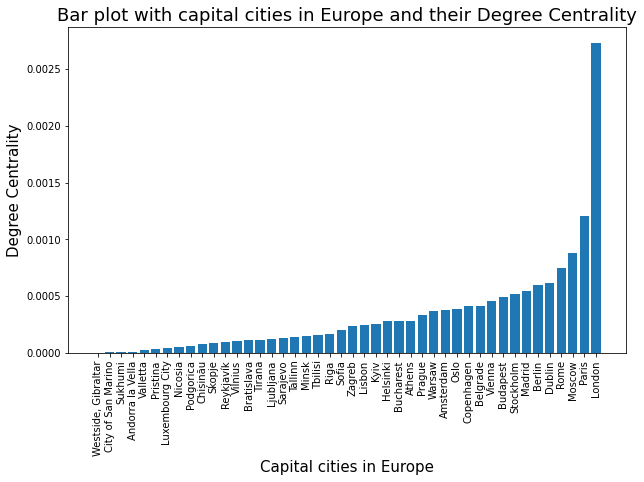

In [234]:
# Barplot PageRank
euCap_PR_sorted = euCap_result.sort_values('pagerank')

plt.figure(figsize=(10,6))
plt.bar('name', 'pagerank',data=euCap_PR_sorted)
plt.xlabel("Capital cities in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with capital cities in Europe and their PageRank", size=18)
plt.savefig("../plots/plots_euCap/euCap_barplot_PR_asc.png", bbox_inches="tight")

# Barplot Degree Centrality
euCap_DC_sorted = euCap_result.sort_values('degree')

plt.figure(figsize=(10,6))
plt.bar('name', 'degree',data=euCap_DC_sorted)
plt.xlabel("Capital cities in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("Degree Centrality", size=15)
plt.title("Bar plot with capital cities in Europe and their Degree Centrality", size=18)
plt.savefig("../plots/plots_euCap/euCap_barplot_DC_asc.png", bbox_inches="tight")

In [7]:
# read survey data into dataframe
df_survey_euCap = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/sv_european_capital_cities_prep.csv", sep=';')
df_survey_euCap.rename(columns={"uri": "resource"}, inplace=True) #rename column to match GCM dataframe

df_survey_euCap.head()

,european_capital_cities,p_age,p_gender,p_education,p_country,p_id,resource
0,berlin,26,Male,Bachelor's degree,Germany,0,http://dbpedia.org/resource/Berlin
1,paris,26,Male,Bachelor's degree,Germany,0,http://dbpedia.org/resource/Paris
2,london,26,Male,Bachelor's degree,Germany,0,http://dbpedia.org/resource/London
3,amsterdam,44,Male,Doctorate (e.g. PhD),Germany,1,http://dbpedia.org/resource/Amsterdam
4,berlin,44,Male,Doctorate (e.g. PhD),Germany,1,http://dbpedia.org/resource/Berlin


In [9]:
#count how often an answer was given in the survey and save into new dataframe
counted_survey_euCap = df_survey_euCap['resource'].value_counts()

df_euCap_survey_counted = pd.DataFrame({'resource':counted_survey_euCap.index, 'amount':counted_survey_euCap.values})

#euCap_result.name = euCap_result.name.str.lower()

df_euCap_survey_gcm = pd.merge(df_euCap_survey_counted,
                 euCap_result[['resource','name', 'degree','pagerank']],
                 on='resource', 
                 how='left')

# assign all answers that were not matchable a PR of 0 (altough per definition of PR not possible) to allow plotting. Alternative: drop from df?
#df_euCap_survey_gcm.pagerank = df_euCap_survey_gcm.pagerank.fillna(0)
#df_euCap_survey_gcm.degree = df_euCap_survey_gcm.degree.fillna(0)

df_euCap_survey_gcm

,resource,amount,name,degree,pagerank
0,http://dbpedia.org/resource/Berlin,84,Berlin,0.000604,0.000087
1,http://dbpedia.org/resource/Paris,74,Paris,0.001208,0.000170
2,http://dbpedia.org/resource/London,45,London,0.002729,0.000342
3,http://dbpedia.org/resource/Rome,29,Rome,0.000749,0.000099
4,http://dbpedia.org/resource/Madrid,19,Madrid,0.000546,0.000077
5,http://dbpedia.org/resource/Vienna,9,Vienna,0.000461,0.000067
6,http://dbpedia.org/resource/Brussels,8,NaN,NaN,NaN
7,http://dbpedia.org/resource/Warsaw,7,Warsaw,0.000370,0.000059
8,http://dbpedia.org/resource/Copenhagen,7,Copenhagen,0.000417,0.000072
9,http://dbpedia.org/resource/Helsinki,5,Helsinki,0.000281,0.000044


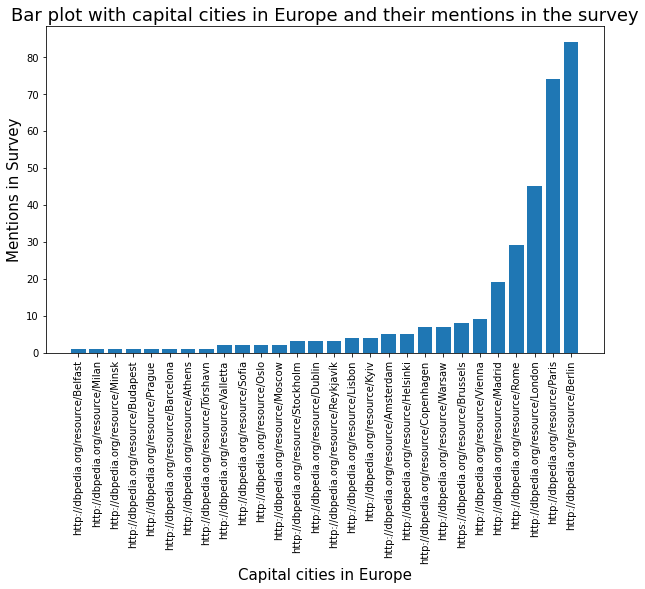

In [238]:
df_euCap_survey_counted_and_sorted = df_euCap_survey_counted.sort_values('amount')

plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('resource', 'amount',data=df_euCap_survey_counted_and_sorted)
plt.xlabel("Capital cities in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("Mentions in Survey", size=15)
plt.title("Bar plot with capital cities in Europe and their mentions in the survey", size=18)
plt.savefig("../plots/plots_euCap/euCapital_barplot_SV_asc.png", bbox_inches="tight")

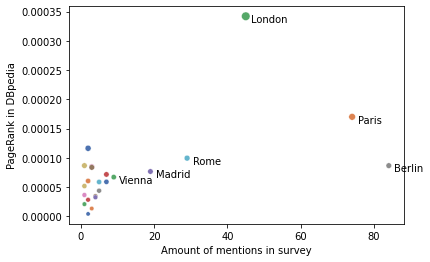

In [239]:
# Scatterplot between PageRank and Survey Results for EU capital cities

sns.scatterplot(data=df_euCap_survey_gcm, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")

#Annotate data points
labels = df_euCap_survey_gcm['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_euCap_survey_gcm.amount[i]+1.5, df_euCap_survey_gcm.pagerank[i]-0.00001))
    if i == 5:
        break
        
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.resource=='http://dbpedia.org/resource/Berlin'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='http://dbpedia.org/resource/Berlin'],"Berlin")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='paris']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='paris'],"Paris")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='london']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='london'],"London")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='moscow']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='moscow'],"Moscow")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='rome']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='rome'],"Rome")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='madrid']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='madrid'],"Madrid")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='budapest']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='budapest'],"Budapest")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='stockholm']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='stockholm'],"Stockholm")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')

plt.savefig("../plots/plots_euCap/euCap_scatter_SurveyXpr_asc.png", bbox_inches="tight")

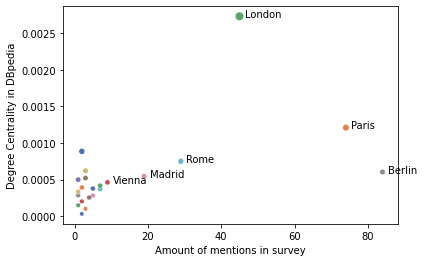

In [240]:
# Scatterplot between Degree Centrality and Survey Results for EU capital cities

sns.scatterplot(data=df_euCap_survey_gcm, x="amount", y="degree", size="degree", legend=False, hue="degree", palette="deep")

#Annotate data points
labels = df_euCap_survey_gcm['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_euCap_survey_gcm.amount[i]+1.5, df_euCap_survey_gcm.degree[i]-0.00001))
    if i == 5:
        break
        
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='berlin'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='berlin'],"Berlin")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='paris'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='paris'],"Paris")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='london'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='london'],"London")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='moscow'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='moscow'],"Moscow")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='rome'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='rome'],"Rome")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='madrid'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='madrid'],"Madrid")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('Degree Centrality in DBpedia')


#for i in range(df_euCap_survey_pr.shape[0]):
 #   plt.text(x=df_euCap_survey_pr.amount[i]+0.3,y=df_euCap_survey_pr.pagerank[i]+0.3,s=df_euCap_survey_pr.name[i], fontdict=dict(color='red',size=10), bbox=dict(facecolor='yellow',alpha=0.5))
#plt.xticks(rotation=90);
plt.savefig("../plots/plots_euCap/euCap_scatter_SurveyXdc_asc.png", bbox_inches="tight")

In [241]:
df_euCap_regression = df_euCap_survey_gcm.copy()
df_euCap_regression = df_euCap_regression.dropna() # custom for potus to drop value with index 0 as it is no potus entity
df_euCap_regression

,resource,amount,name,degree,pagerank
0,http://dbpedia.org/resource/Berlin,84,Berlin,0.000604,0.000087
1,http://dbpedia.org/resource/Paris,74,Paris,0.001208,0.000170
2,http://dbpedia.org/resource/London,45,London,0.002729,0.000342
3,http://dbpedia.org/resource/Rome,29,Rome,0.000749,0.000099
4,http://dbpedia.org/resource/Madrid,19,Madrid,0.000546,0.000077
5,http://dbpedia.org/resource/Vienna,9,Vienna,0.000461,0.000067
7,http://dbpedia.org/resource/Warsaw,7,Warsaw,0.000370,0.000059
8,http://dbpedia.org/resource/Copenhagen,7,Copenhagen,0.000417,0.000072
9,http://dbpedia.org/resource/Helsinki,5,Helsinki,0.000281,0.000044
10,http://dbpedia.org/resource/Amsterdam,5,Amsterdam,0.000377,0.000059


The coefficient is: [[1.652618e-06]]
The intercept is: [5.27244391e-05]


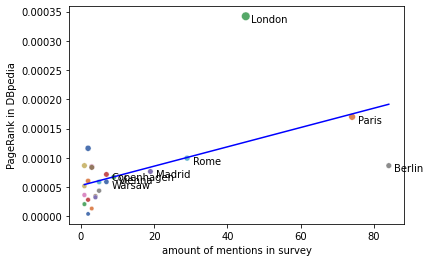

In [285]:
lm_euCap = linear_model.LinearRegression()

pr_array_euCap = df_euCap_regression['pagerank'].to_numpy()
pr_array_euCap = pr_array_euCap.reshape(-1, 1)
sv_array_euCap = df_euCap_regression['amount'].to_numpy()
sv_array_euCap = sv_array_euCap.reshape(-1, 1)

lm_euCap.fit(sv_array_euCap, pr_array_euCap) # fitting the model

print("The coefficient is:", lm_euCap.coef_)
print("The intercept is:",lm_euCap.intercept_)


#Plot the data
sns.scatterplot(data=df_euCap_regression, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")

#Annotate data points
labels = df_euCap_survey_gcm['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_euCap_survey_gcm.amount[i]+1.5, df_euCap_survey_gcm.pagerank[i]-0.00001))
    if i == 8:
        break
y_pred = lm_euCap.predict(sv_array_euCap)
plt.plot(sv_array_euCap, y_pred, color = "b")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')

plt.savefig("../plots/plots_euCap/euCap_regression_surveyXpr_asc.png", bbox_inches="tight")
plt.show()

The coefficient is: [[1.27961002e-05]]
The intercept is: [0.00035905]


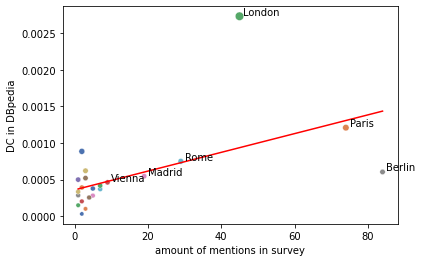

In [284]:
lm_euCap = linear_model.LinearRegression()

dc_array_euCap = df_euCap_regression['degree'].to_numpy()
dc_array_euCap = dc_array_euCap.reshape(-1, 1)
sv_array_euCap = df_euCap_regression['amount'].to_numpy()
sv_array_euCap = sv_array_euCap.reshape(-1, 1)

lm_euCap.fit(sv_array_euCap, dc_array_euCap) # fitting the model

print("The coefficient is:", lm_euCap.coef_)
print("The intercept is:",lm_euCap.intercept_)


#Plot the data
sns.scatterplot(data=df_euCap_regression, x="amount", y="degree", size="degree", legend=False, hue="degree", palette="deep")

#Annotate data points
labels = df_euCap_survey_gcm['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_euCap_survey_gcm.amount[i]+1, df_euCap_survey_gcm.degree[i]+0.00002))
    if i == 5:
        break
y_pred = lm_euCap.predict(sv_array_euCap)
plt.plot(sv_array_euCap, y_pred, color = "r")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('amount of mentions in survey')
plt.ylabel('DC in DBpedia')

plt.savefig("../plots/plots_euCap/euCap_regression_surveyXdc_asc.png", bbox_inches="tight")
plt.show()

### EU country

In [244]:
# EU countries
euCou_result = pd.merge(df_euCou,
                 df_gcm[['resource','degree', 'pagerank']],
                 on='resource', 
                 how='left')

euCou_result

,resource,name,degree,pagerank
0,http://dbpedia.org/resource/Austria,Austria,0.001052,0.000149
1,http://dbpedia.org/resource/Estonia,Estonia,0.000923,0.000158
2,http://dbpedia.org/resource/Albania,Albania,0.000293,0.000038
3,http://dbpedia.org/resource/Andorra,Andorra,0.000034,0.000006
4,http://dbpedia.org/resource/Azerbaijan,Azerbaijan,0.000757,0.000141
5,http://dbpedia.org/resource/Belarus,Belarus,0.000250,0.000037
6,http://dbpedia.org/resource/Belgium,Belgium,0.000886,0.000149
7,http://dbpedia.org/resource/Bosnia_and_Herzego...,Bosnia and Herzegovina,0.000710,0.000089
8,http://dbpedia.org/resource/Bulgaria,Bulgaria,0.000802,0.000112
9,http://dbpedia.org/resource/Croatia,Croatia,0.000703,0.000097


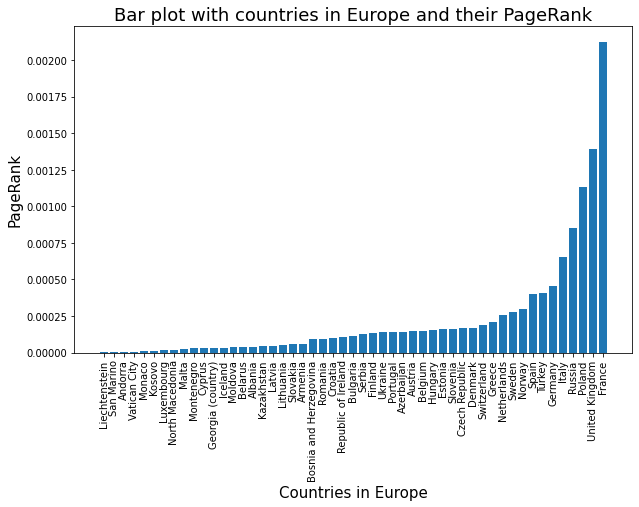

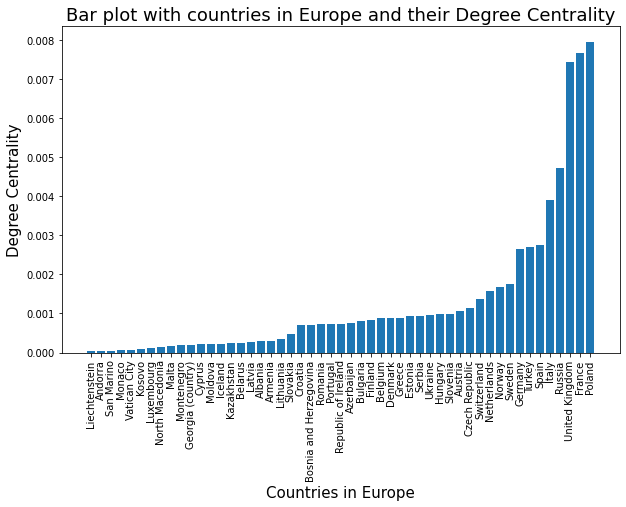

In [245]:
# Barplot PageRank
euCou_PR_sorted = euCou_result.sort_values('pagerank')

plt.figure(figsize=(10,6))
plt.bar('name', 'pagerank',data=euCou_PR_sorted)
plt.xlabel("Countries in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with countries in Europe and their PageRank", size=18)
plt.savefig("../plots/plots_euCou/euCountry_barplot_PR_asc.png", bbox_inches="tight")

# Barplot Degree Centrality
euCou_DC_sorted = euCou_result.sort_values('degree')

plt.figure(figsize=(10,6))
plt.bar('name', 'degree',data=euCou_DC_sorted)
plt.xlabel("Countries in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("Degree Centrality", size=15)
plt.title("Bar plot with countries in Europe and their Degree Centrality", size=18)
plt.savefig("../plots/plots_euCap/euCountry_barplot_DC_asc.png", bbox_inches="tight")

In [252]:
# read survey data into dataframe
df_survey_euCou = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/sv_european_countries_prep.csv", sep=';')
df_survey_euCou.rename(columns={"uri": "resource"}, inplace=True) #rename column to match GCM dataframe

df_survey_euCou.head()

,resource,european_countries,p_age,p_gender,p_education,p_country,p_id
0,http://dbpedia.org/resource/Germany,germany,26,Male,Bachelor's degree,germany,0
1,http://dbpedia.org/resource/France,france,26,Male,Bachelor's degree,germany,0
2,http://dbpedia.org/resource/Italy,italy,26,Male,Bachelor's degree,germany,0
3,http://dbpedia.org/resource/Germany,germany,44,Male,Doctorate (e.g. PhD),germany,1
4,http://dbpedia.org/resource/France,france,44,Male,Doctorate (e.g. PhD),germany,1


In [253]:
#count how often an answer was given in the survey and save into new dataframe
counted_survey_euCou = df_survey_euCou['resource'].value_counts()

df_euCou_survey_counted = pd.DataFrame({'resource':counted_survey_euCou.index, 'amount':counted_survey_euCou.values})

#euCou_result.name = euCou_result.name.str.lower()

df_euCou_survey_gcm = pd.merge(df_euCou_survey_counted,
                 euCou_result[['resource','name', 'degree','pagerank']],
                 on='resource', 
                 how='left')

# assign all answers that were not matchable a PR of 0 (altough per definition of PR not possible) to allow plotting. Alternative: drop from df?
#df_euCou_survey_pr.pagerank = df_euCou_survey_pr.pagerank.fillna(0)
#df_euCap_survey_gcm.degree = df_euCap_survey_gcm.degree.fillna(0)

df_euCou_survey_gcm

,resource,amount,name,degree,pagerank
0,http://dbpedia.org/resource/Germany,80,Germany,0.002659,0.000457
1,http://dbpedia.org/resource/France,66,France,0.007673,0.002124
2,http://dbpedia.org/resource/Italy,38,Italy,0.003908,0.000656
3,http://dbpedia.org/resource/Spain,30,Spain,0.002761,0.000400
4,http://dbpedia.org/resource/United_Kingdom,13,United Kingdom,0.007440,0.001394
5,http://dbpedia.org/resource/Poland,13,Poland,0.007947,0.001131
6,http://dbpedia.org/resource/Austria,12,Austria,0.001052,0.000149
7,http://dbpedia.org/resource/Sweden,11,Sweden,0.001766,0.000279
8,http://dbpedia.org/resource/Switzerland,11,Switzerland,0.001367,0.000191
9,http://dbpedia.org/resource/Denmark,10,Denmark,0.000891,0.000169


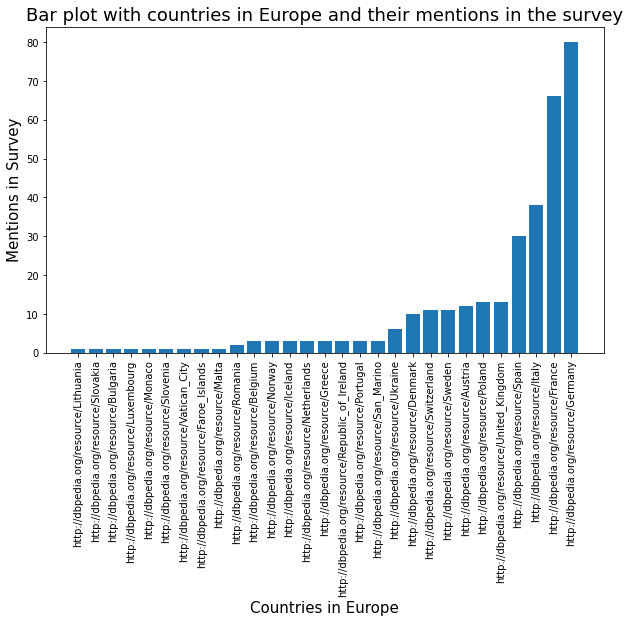

In [254]:
df_euCou_survey_counted_and_sorted = df_euCou_survey_counted.sort_values('amount')

plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('resource', 'amount',data=df_euCou_survey_counted_and_sorted)
plt.xlabel("Countries in Europe", size=15)
plt.xticks(rotation=90)
plt.ylabel("Mentions in Survey", size=15)
plt.title("Bar plot with countries in Europe and their mentions in the survey", size=18)
plt.savefig("../plots/plots_euCou/euCountries_barplot_SV_asc.png", bbox_inches="tight")

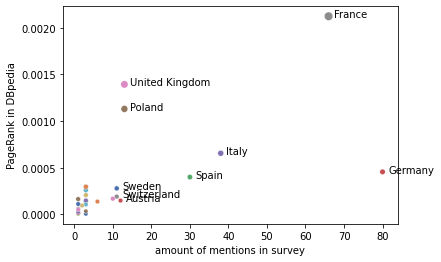

In [255]:
sns.scatterplot(data=df_euCou_survey_gcm, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")

#Annotate data points
labels = df_euCou_survey_gcm['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_euCou_survey_gcm.amount[i]+1.5, df_euCou_survey_gcm.pagerank[i]-0.00001))
    if i == 8:
        break
        
#plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='germany']-4.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='germany'],"GE")
#plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='france']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='france'],"FR")
#plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='italy']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='italy'],"IT")
#plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='spain']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='spain'],"ES")
#plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='united kingdom']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='united kingdom'],"UK")
#plt.text(df_euCou_survey_pr.amount[df_euCou_survey_pr.name=='poland']+1.5,df_euCou_survey_pr.pagerank[df_euCou_survey_pr.name=='poland'],"PL")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='budapest']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='budapest'],"Budapest")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='stockholm']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='stockholm'],"Stockholm")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')


plt.savefig("../plots/plots_euCou/euCou_scatter_SurveyXpr_asc.png", bbox_inches="tight")

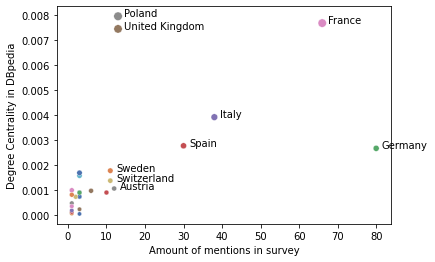

In [256]:
# Scatterplot between Degree Centrality and Survey Results for EU capital cities

sns.scatterplot(data=df_euCou_survey_gcm, x="amount", y="degree", size="degree", legend=False, hue="degree", palette="deep")

#Annotate data points
labels = df_euCou_survey_gcm['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_euCou_survey_gcm.amount[i]+1.5, df_euCou_survey_gcm.degree[i]-0.00001))
    if i == 8:
        break
        
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='berlin'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='berlin'],"Berlin")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='paris'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='paris'],"Paris")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='london'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='london'],"London")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='moscow'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='moscow'],"Moscow")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='rome'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='rome'],"Rome")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='madrid'],df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='madrid'],"Madrid")

#plt.title('Scatter plot with EU countries and their DC', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('Degree Centrality in DBpedia')

plt.savefig("../plots/plots_euCou/euCou_scatter_SurveyXdc_asc.png", bbox_inches="tight")

In [257]:
df_euCou_regression = df_euCou_survey_gcm.copy()
df_euCou_regression = df_euCou_regression.drop(20) # custom for potus to drop value with index 0 as it is no potus entity
df_euCou_regression

,resource,amount,name,degree,pagerank
0,http://dbpedia.org/resource/Germany,80,Germany,0.002659,0.000457
1,http://dbpedia.org/resource/France,66,France,0.007673,0.002124
2,http://dbpedia.org/resource/Italy,38,Italy,0.003908,0.000656
3,http://dbpedia.org/resource/Spain,30,Spain,0.002761,0.000400
4,http://dbpedia.org/resource/United_Kingdom,13,United Kingdom,0.007440,0.001394
5,http://dbpedia.org/resource/Poland,13,Poland,0.007947,0.001131
6,http://dbpedia.org/resource/Austria,12,Austria,0.001052,0.000149
7,http://dbpedia.org/resource/Sweden,11,Sweden,0.001766,0.000279
8,http://dbpedia.org/resource/Switzerland,11,Switzerland,0.001367,0.000191
9,http://dbpedia.org/resource/Denmark,10,Denmark,0.000891,0.000169


In [258]:
lm_euCou = linear_model.LinearRegression()

pr_array_euCou = df_euCou_regression['pagerank'].to_numpy()
pr_array_euCou = pr_array_euCou.reshape(-1, 1)
sv_array_euCou = df_euCou_regression['amount'].to_numpy()
sv_array_euCou = sv_array_euCou.reshape(-1, 1)

lm_euCou.fit(sv_array_euCou, pr_array_euCou) # fitting the model

print("The coefficient is:", lm_euCou.coef_)
print("The intercept is:",lm_euCou.intercept_)

The coefficient is: [[1.53475081e-05]]
The intercept is: [0.00013776]


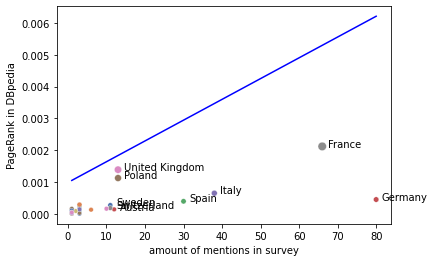

In [283]:
sns.scatterplot(data=df_euCou_regression, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")

#Annotate data points
labels = df_euCou_survey_gcm['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_euCou_survey_gcm.amount[i]+1.5, df_euCou_survey_gcm.pagerank[i]-0.00001))
    if i == 8:
        break
y_pred = lm_euCou.predict(sv_array_euCou)
plt.plot(sv_array_euCou, y_pred, color = "b")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')

plt.savefig("../plots/plots_euCou/euCou_regression_surveyXpr_asc.png", bbox_inches="tight")
plt.show()

The coefficient is: [[6.52090758e-05]]
The intercept is: [0.00099114]


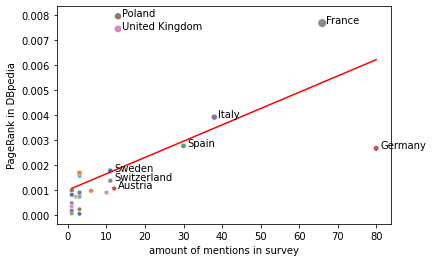

In [281]:
lm_euCou = linear_model.LinearRegression()

dc_array_euCou = df_euCou_regression['degree'].to_numpy()
dc_array_euCou = dc_array_euCou.reshape(-1, 1)
sv_array_euCou = df_euCou_regression['amount'].to_numpy()
sv_array_euCou = sv_array_euCou.reshape(-1, 1)

lm_euCou.fit(sv_array_euCou, dc_array_euCou) # fitting the model

print("The coefficient is:", lm_euCou.coef_)
print("The intercept is:",lm_euCou.intercept_)

# Plot the data
sns.scatterplot(data=df_euCou_regression, x="amount", y="degree", size="pagerank", legend=False, hue="pagerank", palette="deep")

#Annotate data points
labels = df_euCou_survey_gcm['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_euCou_survey_gcm.amount[i]+1, df_euCou_survey_gcm.degree[i]))
    if i == 8:
        break
y_pred = lm_euCou.predict(sv_array_euCou)
plt.plot(sv_array_euCou, y_pred, color = "r")

#plt.title('Scatter plot with EU capital cities and their PageRank', size=18)
plt.xlabel('amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')

plt.savefig("../plots/plots_euCou/euCou_regression_surveyXdc_asc.png", bbox_inches="tight")
plt.show()

### POTUS

In [261]:
# Match the GCMs to the queried POTUS category
potus_result = pd.merge(df_potus,
                 #df_pr[['resource_id','resource', 'pagerank']],
                 df_gcm[['resource', 'degree','pagerank']],
                 on='resource', 
                 how='left')

#potus_result = potus_result.drop(25) # custom for potus to drop value with index 0 as it is no potus entity

potus_result.size

184

In [262]:
potus_result.head()

,resource,name,degree,pagerank
0,http://dbpedia.org/resource/Joe_Biden,Joe Biden,0.000124,0.000023
1,http://dbpedia.org/resource/Benjamin_Harrison,Benjamin Harrison,0.000014,0.000002
2,http://dbpedia.org/resource/Barack_Obama,Barack Obama,0.000233,0.000040
3,http://dbpedia.org/resource/Abraham_Lincoln,Abraham Lincoln,0.000018,0.000003
4,http://dbpedia.org/resource/Andrew_Jackson,Andrew Jackson,0.000019,0.000003


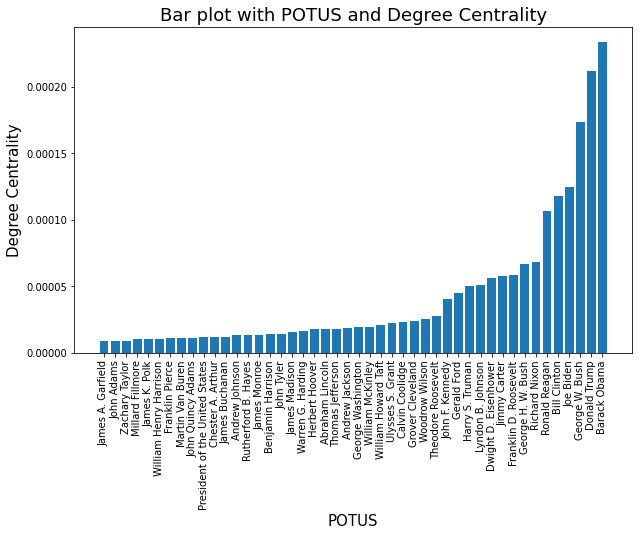

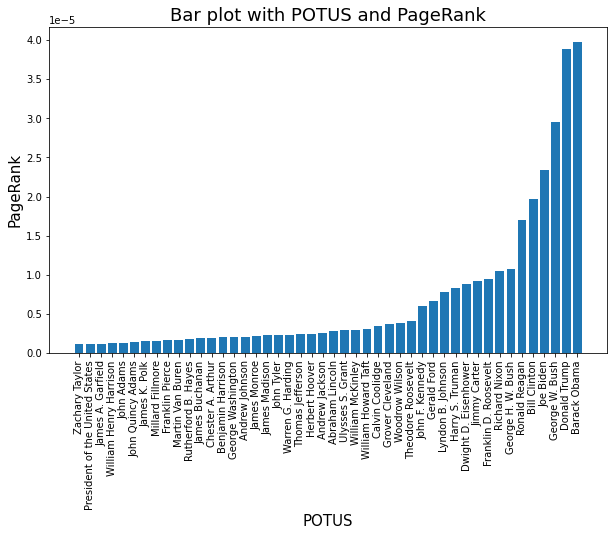

In [263]:
# Create dataframes with sorted DC and PR for plotting
potus_sorted_dg = potus_result.sort_values('degree')
potus_sorted_pr = potus_result.sort_values('pagerank')

# bar plot with DC
plt.figure(figsize=(10,6))
plt.bar('name', 'degree',data=potus_sorted_dg)
plt.xlabel("POTUS", size=15)
plt.xticks(rotation=90)
plt.ylabel("Degree Centrality", size=15)
plt.title("Bar plot with POTUS and Degree Centrality", size=18)
plt.savefig("../plots/plots_potus/potus_barplot_DC_asc.png", bbox_inches="tight")

# bar plot with PR
plt.figure(figsize=(10,6))
plt.bar('name', 'pagerank',data=potus_sorted_pr)
plt.xlabel("POTUS", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with POTUS and PageRank", size=18)
plt.savefig("../plots/plots_potus/potus_barplot_PR_asc.png", bbox_inches="tight")

In [264]:
# Read survey data into dataframe
df_survey_potus = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/sv_potus_prep.csv", sep=';')
df_survey_potus.rename(columns={"uri": "resource"}, inplace=True) #rename column to match GCM dataframe

df_survey_potus.head()

,resource,us_presidents,p_age,p_gender,p_education,p_country,p_id
0,http://dbpedia.org/resource/Barack_Obama,barackobama,26,Male,Bachelor's degree,Germany,0
1,http://dbpedia.org/resource/Joe_Biden,joebiden,26,Male,Bachelor's degree,Germany,0
2,http://dbpedia.org/resource/George_Washington,georgewashington,26,Male,Bachelor's degree,Germany,0
3,http://dbpedia.org/resource/Joe_Biden,joebiden,44,Male,Doctorate (e.g. PhD),Germany,1
4,http://dbpedia.org/resource/George_W._Bush,goergew.bush,44,Male,Doctorate (e.g. PhD),Germany,1


In [265]:
# Count how often an unique answer was given in the survey and save to new dataframe
counted_survey_potus = df_survey_potus['resource'].value_counts()

df_survey_counted_potus = pd.DataFrame({'resource':counted_survey_potus.index, 'amount':counted_survey_potus.values})

#euCap_result.name = euCap_result.name.str.lower()

df_survey_gcm_potus = pd.merge(df_survey_counted_potus,
                 potus_result[['resource','name', 'degree','pagerank']],
                 on='resource', 
                 how='left')

# assign all answers that were not matchable a PR of 0 (altough per definition of PR not possible) to allow plotting. Alternative: drop from df?
#df_euCap_survey_gcm.pagerank = df_euCap_survey_gcm.pagerank.fillna(0)
#df_euCap_survey_gcm.degree = df_euCap_survey_gcm.degree.fillna(0)


#euCap_result['resource'] = euCap_result.apply(lambda row: node_path(row), axis=1)
df_survey_gcm_potus

,resource,amount,name,degree,pagerank
0,http://dbpedia.org/resource/Barack_Obama,77,Barack Obama,0.000233,0.000040
1,http://dbpedia.org/resource/Donald_Trump,59,Donald Trump,0.000212,0.000039
2,http://dbpedia.org/resource/Joe_Biden,50,Joe Biden,0.000124,0.000023
3,http://dbpedia.org/resource/George_W._Bush,37,George W. Bush,0.000174,0.000030
4,http://dbpedia.org/resource/Abraham_Lincoln,19,Abraham Lincoln,0.000018,0.000003
5,http://dbpedia.org/resource/John_F._Kennedy,17,John F. Kennedy,0.000041,0.000006
6,http://dbpedia.org/resource/Bill_Clinton,15,Bill Clinton,0.000118,0.000020
7,http://dbpedia.org/resource/George_Washington,14,George Washington,0.000019,0.000002
8,http://dbpedia.org/resource/Franklin_D._Roosevelt,10,Franklin D. Roosevelt,0.000058,0.000010
9,http://dbpedia.org/resource/Ronald_Reagan,5,Ronald Reagan,0.000107,0.000017


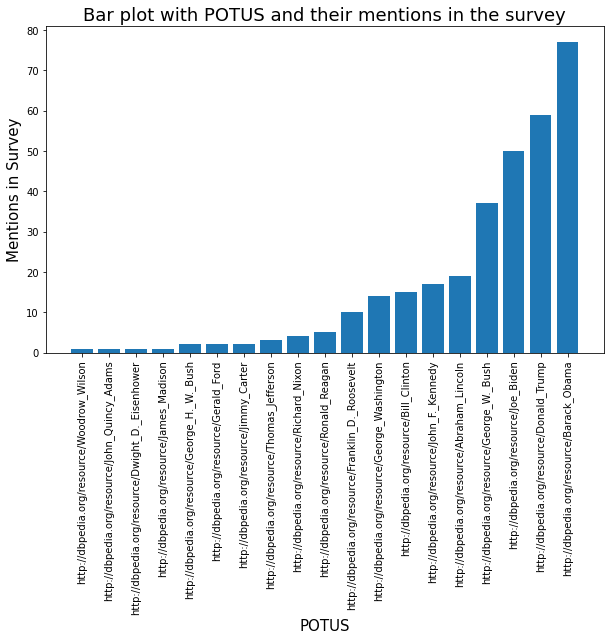

In [266]:
df_survey_counted_and_sorted_potus = df_survey_counted_potus.sort_values('amount')

plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('resource', 'amount',data=df_survey_counted_and_sorted_potus)
plt.xlabel("POTUS", size=15)
plt.xticks(rotation=90)
plt.ylabel("Mentions in Survey", size=15)
plt.title("Bar plot with POTUS and their mentions in the survey", size=18)
plt.savefig("../plots/plots_potus/potus_barplot_SV_asc.png", bbox_inches="tight")

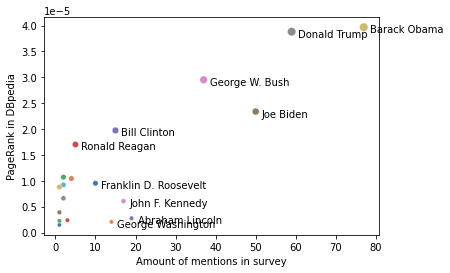

In [267]:
# Scatterplot between PageRank and Survey Results for POTUS
sns.scatterplot(data=df_survey_gcm_potus, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")

#Annotate data points
labels = df_survey_gcm_potus['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_survey_gcm_potus.amount[i]+1.5, df_survey_gcm_potus.pagerank[i]-0.000001))
    if i == 9:
        break

#plt.text(df_survey_gcm_potus.amount[df_survey_gcm_potus.resource=='http://dbpedia.org/resource/Barack_Obama']-9.5,df_survey_gcm_potus.pagerank[df_survey_gcm_potus.resource=='http://dbpedia.org/resource/Barack_Obama'],"Obama")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='paris']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='paris'],"Paris")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='london']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='london'],"London")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='moscow']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='moscow'],"Moscow")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='rome']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='rome'],"Rome")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='madrid']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='madrid'],"Madrid")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='budapest']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='budapest'],"Budapest")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='stockholm']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='stockholm'],"Stockholm")

#plt.title('Scatter plot with POTUS and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')


plt.savefig("../plots/plots_potus/potus_scatter_surveyXpr_asc.png", bbox_inches="tight")

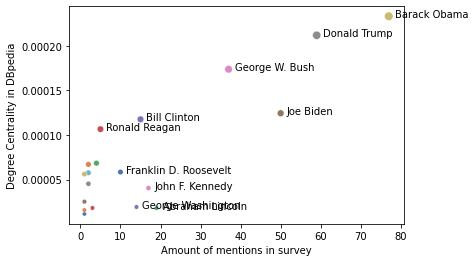

In [268]:
# Scatterplot between Degree Centrality and Survey Results for POTUS
sns.scatterplot(data=df_survey_gcm_potus, x="amount", y="degree", size="degree", legend=False, hue="degree", palette="deep")

#Annotate data points
labels = df_survey_gcm_potus['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_survey_gcm_potus.amount[i]+1.5, df_survey_gcm_potus.degree[i]-0.000001))
    if i == 9:
        break

#plt.text(df_survey_gcm_potus.amount[df_survey_gcm_potus.resource=='http://dbpedia.org/resource/Barack_Obama']-9.5,df_survey_gcm_potus.pagerank[df_survey_gcm_potus.resource=='http://dbpedia.org/resource/Barack_Obama'],"Obama")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='paris']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='paris'],"Paris")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='london']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='london'],"London")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='moscow']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='moscow'],"Moscow")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='rome']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='rome'],"Rome")
#plt.text(df_euCap_survey_gcm.amount[df_euCap_survey_gcm.name=='madrid']+1.5,df_euCap_survey_gcm.pagerank[df_euCap_survey_gcm.name=='madrid'],"Madrid")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='budapest']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='budapest'],"Budapest")
#plt.text(df_euCap_survey_pr.amount[df_euCap_survey_pr.name=='stockholm']+1.5,df_euCap_survey_pr.pagerank[df_euCap_survey_pr.name=='stockholm'],"Stockholm")

#plt.title('Scatter plot with POTUS and their DC', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('Degree Centrality in DBpedia')

plt.savefig("../plots/plots_potus/potus_scatter_surveyXdc_asc.png", bbox_inches="tight")

The coefficient is: [[2.55625972e-06]]
The intercept is: [3.43047843e-05]


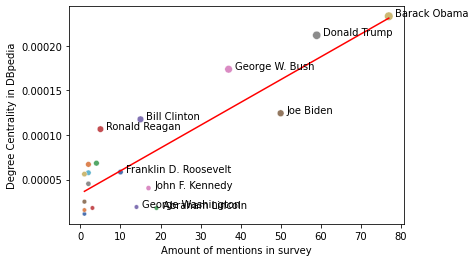

<Figure size 432x288 with 0 Axes>

In [269]:
# DC Regression test for POTUS

df_potus_regression = df_survey_gcm_potus.copy()

lm_potus = linear_model.LinearRegression()

dc_array_potus = df_potus_regression['degree'].to_numpy()
dc_array_potus = dc_array_potus.reshape(-1, 1)
sv_array_potus = df_potus_regression['amount'].to_numpy()
sv_array_potus = sv_array_potus.reshape(-1, 1)

lm_potus.fit(sv_array_potus, dc_array_potus) # fitting the model

print("The coefficient is:", lm_potus.coef_)
print("The intercept is:",lm_potus.intercept_)

# Scatter with regression function
sns.scatterplot(data=df_potus_regression, x="amount", y="degree", size="degree", legend=False, hue="degree", palette="deep")

#Annotate data points
labels = df_potus_regression['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_potus_regression.amount[i]+1.5, df_potus_regression.degree[i]))
    if i == 9:
        break
y_pred = lm_potus.predict(sv_array_potus)
plt.plot(sv_array_potus, y_pred, color = "r")

#plt.title('Regression with POTUS and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('Degree Centrality in DBpedia')
plt.show()

plt.savefig("../plots/plots_potus/potus_regression_surveyXdc_asc.png", bbox_inches="tight")

The coefficient is: [[4.68068636e-07]]
The intercept is: [4.97618827e-06]


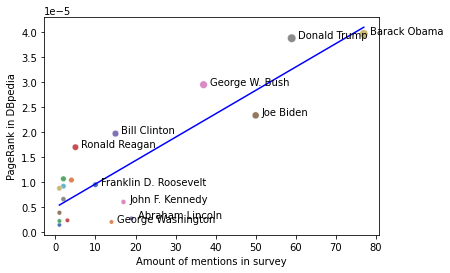

<Figure size 432x288 with 0 Axes>

In [270]:
# Regression test for POTUS

df_potus_regression = df_survey_gcm_potus.copy()

lm_potus = linear_model.LinearRegression()

pr_array_potus = df_potus_regression['pagerank'].to_numpy()
pr_array_potus = pr_array_potus.reshape(-1, 1)
sv_array_potus = df_potus_regression['amount'].to_numpy()
sv_array_potus = sv_array_potus.reshape(-1, 1)

lm_potus.fit(sv_array_potus, pr_array_potus) # fitting the model

print("The coefficient is:", lm_potus.coef_)
print("The intercept is:",lm_potus.intercept_)

# Scatter with regression function
sns.scatterplot(data=df_potus_regression, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")

#Annotate data points
labels = df_potus_regression['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_potus_regression.amount[i]+1.5, df_potus_regression.pagerank[i]))
    if i == 9:
        break
y_pred = lm_potus.predict(sv_array_potus)
plt.plot(sv_array_potus, y_pred, color = "b")

#plt.title('Regression with POTUS and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')
plt.show()

plt.savefig("../plots/plots_potus/potus_regression_surveyXpr_asc.png", bbox_inches="tight")

### Birds

In [276]:
# Match the GCMs to the queried POTUS category
birds_result = pd.merge(df_bird,
                 df_gcm[['resource', 'degree','pagerank']],
                 on='resource', 
                 how='left')

#potus_result = potus_result.drop(25) # custom for potus to drop value with index 0 as it is no potus entity

birds_result.size

40000

In [277]:
birds_result.head()

,resource,name,degree,pagerank
0,http://dbpedia.org/resource/2007–08_KFC_Twenty...,2007–08 KFC Twenty20 Big Bash,NaN,NaN
1,http://dbpedia.org/resource/African_goshawk,African goshawk,NaN,NaN
2,http://dbpedia.org/resource/African_pitta,African pitta,NaN,NaN
3,http://dbpedia.org/resource/African_red-eyed_b...,African red-eyed bulbul,NaN,NaN
4,http://dbpedia.org/resource/Al_Shouf_Cedar_Nat...,Al Shouf Cedar Nature Reserve,4.852407e-07,5.485627e-08


Text(0.5, 1.0, 'Bar plot with Birds and PageRank')

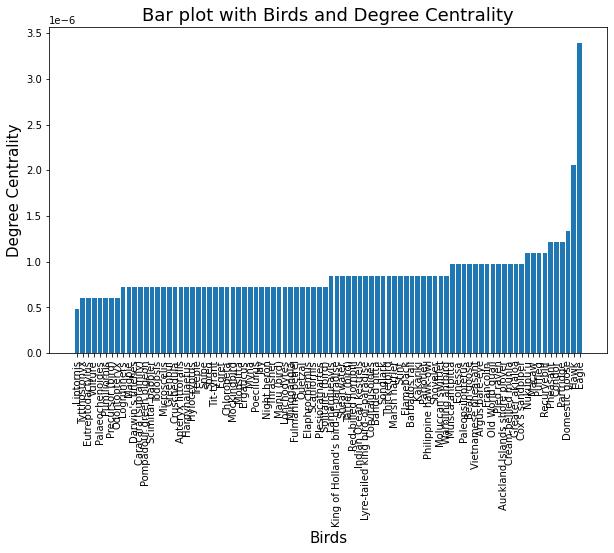

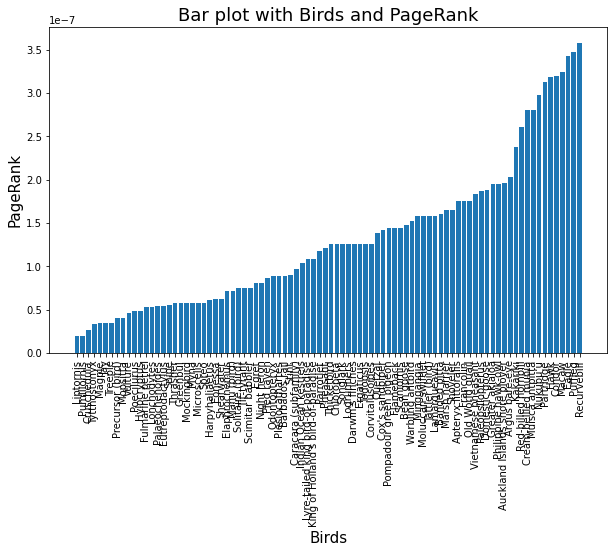

In [112]:
# Create dataframes with sorted DC and PR for plotting
birds_sorted_dc = birds_result.sort_values('degree')
birds_sorted_pr = birds_result.sort_values('pagerank')

# bar plot with DC
plt.figure(figsize=(10,6))
plt.bar('name', 'degree',data=birds_sorted_dc)
plt.xlabel("Birds", size=15)
plt.xticks(rotation=90)
plt.ylabel("Degree Centrality", size=15)
plt.title("Bar plot with Birds and Degree Centrality", size=18)
#plt.savefig("../plots/plots_birds/birds_barplot_DC_asc.png", bbox_inches="tight")

# bar plot with PR
plt.figure(figsize=(10,6))
plt.bar('name', 'pagerank',data=birds_sorted_pr)
plt.xlabel("Birds", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with Birds and PageRank", size=18)
#plt.savefig("../plots/plots_birds/birds_barplot_PR_asc.png", bbox_inches="tight")

In [278]:
# Read survey data into dataframe
df_survey_birds = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/sv_birds_prep.csv", sep=';')
df_survey_birds.rename(columns={"uri": "resource"}, inplace=True) #rename column to match GCM dataframe

df_survey_birds.head()

,resource,birds,p_age,p_gender,p_education,p_country,p_id
0,http://dbpedia.org/resource/Robin,robin,26,Male,Bachelor's degree,germany,0
1,http://dbpedia.org/resource/Mockingbird,mockingbird,26,Male,Bachelor's degree,germany,0
2,http://dbpedia.org/resource/Pelican,pelican,26,Male,Bachelor's degree,germany,0
3,http://dbpedia.org/resource/Ostrich,ostrich,44,Male,Doctorate (e.g. PhD),germany,1
4,http://dbpedia.org/resource/Owl,owl,44,Male,Doctorate (e.g. PhD),germany,1


In [280]:
# Count how often an unique answer was given in the survey and save to new dataframe
counted_survey_birds = df_survey_birds['resource'].value_counts()

df_survey_counted_birds = pd.DataFrame({'resource':counted_survey_birds.index, 'amount':counted_survey_birds.values})

#euCap_result.name = euCap_result.name.str.lower()

df_survey_gcm_birds = pd.merge(df_survey_counted_birds,
                 birds_result[['resource', 'degree','pagerank']],
                 #df_gcm[['resource', 'degree','pagerank']],
                 on='resource', 
                 how='left')

# assign all answers that were not matchable a PR of 0 (altough per definition of PR not possible) to allow plotting. Alternative: drop from df?
#df_euCap_survey_gcm.pagerank = df_euCap_survey_gcm.pagerank.fillna(0)
#df_euCap_survey_gcm.degree = df_euCap_survey_gcm.degree.fillna(0)


#euCap_result['resource'] = euCap_result.apply(lambda row: node_path(row), axis=1)
df_survey_gcm_birds

,resource,amount,degree,pagerank
0,http://dbpedia.org/resource/Eagle,45,3.396685e-06,3.428138e-07
1,http://dbpedia.org/resource/Sparrow,22,NaN,NaN
2,http://dbpedia.org/resource/Common_blackbird,19,1.213102e-07,1.819668e-08
3,http://dbpedia.org/resource/Robin,18,NaN,NaN
4,http://dbpedia.org/resource/Columbidae,15,NaN,NaN
5,http://dbpedia.org/resource/Hummingbird,12,NaN,NaN
6,http://dbpedia.org/resource/Owl,10,NaN,NaN
7,http://dbpedia.org/resource/Crow,10,NaN,NaN
8,http://dbpedia.org/resource/Parrot,10,NaN,NaN
9,http://dbpedia.org/resource/Raven,9,4.852407e-07,5.612776e-08


Text(0.5, 1.0, 'Bar plot with Birds and their mentions in the survey')

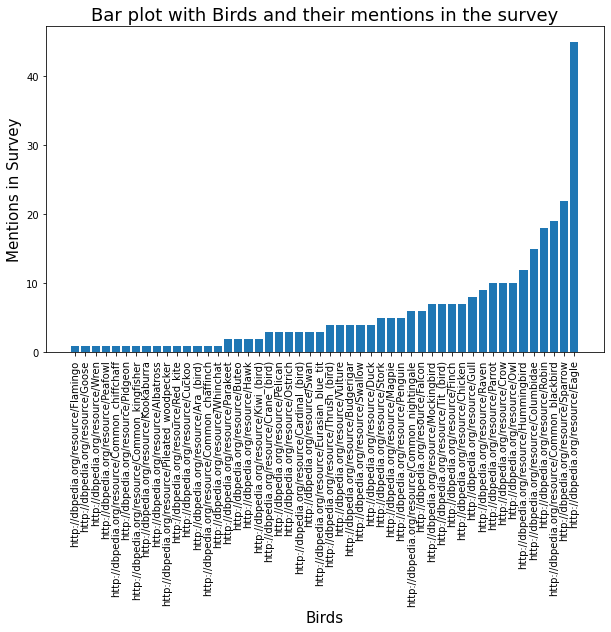

In [175]:
df_survey_counted_and_sorted_birds = df_survey_counted_birds.sort_values('amount')

plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('resource', 'amount',data=df_survey_counted_and_sorted_birds)
plt.xlabel("Birds", size=15)
plt.xticks(rotation=90)
plt.ylabel("Mentions in Survey", size=15)
plt.title("Bar plot with Birds and their mentions in the survey", size=18)
#plt.savefig("../plots/plots_potus/potus_barplot_SV_asc.png", bbox_inches="tight")

KeyError: 1

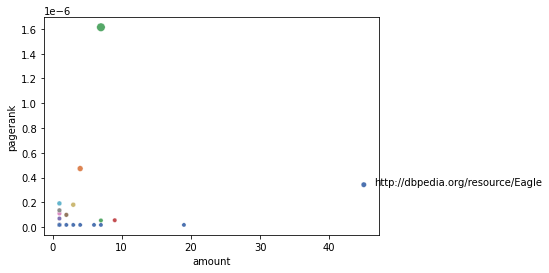

In [290]:
# Regression test for Birds

df_birds_regression = df_survey_gcm_birds.copy()
df_birds_regression = df_birds_regression.dropna(subset=['pagerank', 'degree']) #drop rows with NaN values

lm_birds = linear_model.LinearRegression()

pr_array_birds = df_birds_regression['pagerank'].to_numpy()
pr_array_birds = pr_array_birds.reshape(-1, 1)
sv_array_birds = df_birds_regression['amount'].to_numpy()
sv_array_birds = sv_array_birds.reshape(-1, 1)

lm_birds.fit(sv_array_birds, pr_array_birds) # fitting the model

print("The coefficient is:", lm_birds.coef_)
print("The intercept is:",lm_birds.intercept_)


# Scatter with regression function
sns.scatterplot(data=df_birds_regression, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")

#Annotate data points
labels = df_birds_regression['resource']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_birds_regression.amount[i]+1.5, df_birds_regression.pagerank[i]))
    if i == 9:
        break
y_pred = lm_birds.predict(sv_array_birds)
plt.plot(sv_array_birds, y_pred, color = "b")

#plt.title('Regression with POTUS and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')

#plt.savefig("../plots/plots_potus/potus_regression_surveyXdc_asc.png", bbox_inches="tight")
plt.show()

### Vegetables

In [147]:
# Match the GCMs to the queried POTUS category
vegetables_result = pd.merge(df_vegetable,
                 df_gcm[['resource', 'degree','pagerank']],
                 on='resource', 
                 how='left')

vegetables_result.size

14968

In [148]:
vegetables_result.head()

,resource,name,degree,pagerank
0,http://dbpedia.org/resource/Allium_textile,Allium textile,NaN,NaN
1,http://dbpedia.org/resource/Dal_makhani,Dal makhani,9.704814e-07,9.040180e-08
2,http://dbpedia.org/resource/Ligstroside,Ligstroside,1.213102e-07,1.820492e-08
3,http://dbpedia.org/resource/Lyrick_Studios,Lyrick Studios,1.819653e-06,3.792207e-07
4,http://dbpedia.org/resource/McCoy's_(crisp),McCoy's (crisp),NaN,NaN


Text(0.5, 1.0, 'Bar plot with Vegetables and PageRank')

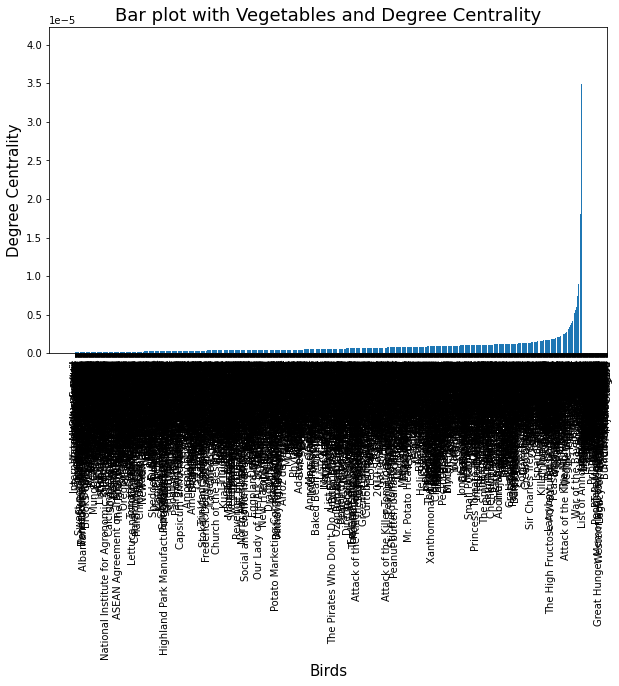

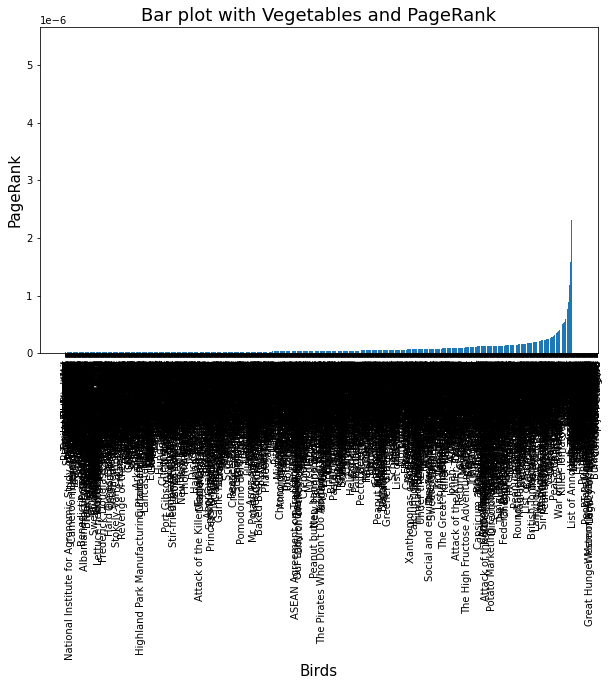

In [149]:
# Create dataframes with sorted DC and PR for plotting
vegetables_sorted_dc = vegetables_result.sort_values('degree')
vegetables_sorted_pr = vegetables_result.sort_values('pagerank')

# bar plot with DC
plt.figure(figsize=(10,6))
plt.bar('name', 'degree',data=vegetables_sorted_dc)
plt.xlabel("Birds", size=15)
plt.xticks(rotation=90)
plt.ylabel("Degree Centrality", size=15)
plt.title("Bar plot with Vegetables and Degree Centrality", size=18)
#plt.savefig("../plots/plots_birds/birds_barplot_DC_asc.png", bbox_inches="tight")

# bar plot with PR
plt.figure(figsize=(10,6))
plt.bar('name', 'pagerank',data=vegetables_sorted_pr)
plt.xlabel("Birds", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with Vegetables and PageRank", size=18)
#plt.savefig("../plots/plots_birds/birds_barplot_PR_asc.png", bbox_inches="tight")

In [152]:
# Read survey data into dataframe
df_survey_vegetables = pd.read_csv("../data/survey_single_cat_files/sv_prep_uri/sv_vegetables_prep.csv", sep=';')
df_survey_vegetables.rename(columns={"uri": "resource"}, inplace=True) #rename column to match GCM dataframe

df_survey_vegetables.head()

,resource,vegetables,p_age,p_gender,p_education,p_country,p_id
0,http://dbpedia.org/resource/Pea,peas,26,Male,Bachelor's degree,germany,0
1,http://dbpedia.org/resource/Carrot,carrot,26,Male,Bachelor's degree,germany,0
2,http://dbpedia.org/resource/Tomato,tomato,26,Male,Bachelor's degree,germany,0
3,http://dbpedia.org/resource/Cucumber,cucumber,44,Male,Doctorate (e.g. PhD),germany,1
4,http://dbpedia.org/resource/Tomato,tomato,44,Male,Doctorate (e.g. PhD),germany,1


In [168]:
# Count how often an unique answer was given in the survey and save to new dataframe
counted_survey_vegetables = df_survey_vegetables['resource'].value_counts()

df_survey_counted_vegetables = pd.DataFrame({'resource':counted_survey_vegetables.index, 'amount':counted_survey_vegetables.values})

#euCap_result.name = euCap_result.name.str.lower()

df_survey_gcm_vegetables = pd.merge(df_survey_counted_vegetables,
                 vegetables_result[['resource','name', 'degree','pagerank']],
                 on='resource', 
                 how='left')

# assign all answers that were not matchable a PR of 0 (altough per definition of PR not possible) to allow plotting. Alternative: drop from df?
#df_euCap_survey_gcm.pagerank = df_euCap_survey_gcm.pagerank.fillna(0)
#df_euCap_survey_gcm.degree = df_euCap_survey_gcm.degree.fillna(0)


#euCap_result['resource'] = euCap_result.apply(lambda row: node_path(row), axis=1)
df_survey_gcm_vegetables

,resource,amount,name,degree,pagerank
0,http://dbpedia.org/resource/Carrot,51,Carrot,7.399920e-06,7.843800e-07
1,http://dbpedia.org/resource/Cucumber,47,Cucumber,4.124546e-06,4.780611e-07
2,http://dbpedia.org/resource/Tomato,43,Tomato,2.219976e-05,2.204319e-06
3,http://dbpedia.org/resource/Potato,19,Potato,3.493733e-05,5.385369e-06
4,http://dbpedia.org/resource/Broccoli,18,Broccoli,1.091792e-06,1.053167e-07
5,http://dbpedia.org/resource/Zucchini,17,Zucchini,1.455722e-06,2.026686e-07
6,http://dbpedia.org/resource/Eggplant,17,Eggplant,4.852407e-06,5.199613e-07
7,http://dbpedia.org/resource/Bell_pepper,14,Bell pepper,5.337647e-06,4.955169e-07
8,http://dbpedia.org/resource/Paprika,11,Paprika,2.426203e-06,2.394780e-07
9,http://dbpedia.org/resource/Onion,11,Onion,4.027498e-05,4.156368e-06


Text(0.5, 1.0, 'Bar plot with Vegetables and their mentions in the survey')

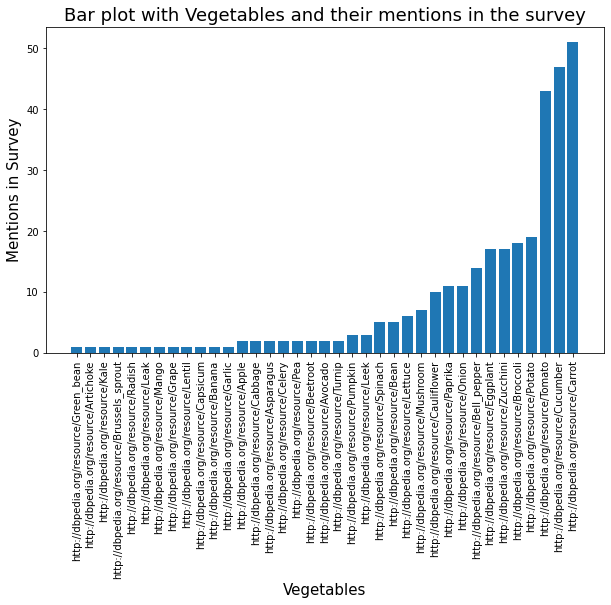

In [155]:
df_survey_counted_and_sorted_vegs= df_survey_counted_vegetables.sort_values('amount')

plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('resource', 'amount',data=df_survey_counted_and_sorted_vegs)
plt.xlabel("Vegetables", size=15)
plt.xticks(rotation=90)
plt.ylabel("Mentions in Survey", size=15)
plt.title("Bar plot with Vegetables and their mentions in the survey", size=18)
#plt.savefig("../plots/plots_vegetables/vegetables_barplot_SV_asc.png", bbox_inches="tight")

The coefficient is: [[2.12832892e-08]]
The intercept is: [5.60508887e-07]


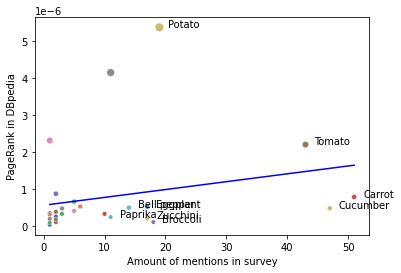

In [287]:
# Regression test for Vegetables

df_vegetables_regression = df_survey_gcm_vegetables.copy()
df_vegetables_regression = df_vegetables_regression.dropna(subset=['pagerank', 'degree']) #drop rows with NaN values

lm_vegs = linear_model.LinearRegression()

pr_array_vegs = df_vegetables_regression['pagerank'].to_numpy()
pr_array_vegs = pr_array_vegs.reshape(-1, 1)
sv_array_vegs = df_vegetables_regression['amount'].to_numpy()
sv_array_vegs = sv_array_vegs.reshape(-1, 1)

lm_vegs.fit(sv_array_vegs, pr_array_vegs) # fitting the model

print("The coefficient is:", lm_vegs.coef_)
print("The intercept is:",lm_vegs.intercept_)


# Scatter with regression function
sns.scatterplot(data=df_vegetables_regression, x="amount", y="pagerank", size="pagerank", legend=False, hue="pagerank", palette="deep")

#Annotate data points
labels = df_vegetables_regression['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_vegetables_regression.amount[i]+1.5, df_vegetables_regression.pagerank[i]))
    if i == 8:
        break
y_pred = lm_vegs.predict(sv_array_vegs)
plt.plot(sv_array_vegs, y_pred, color = "b")

#plt.title('Regression with POTUS and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('PageRank in DBpedia')

plt.savefig("../plots/plots_vegetables/vegetables_regression_surveyXpr_asc.png", bbox_inches="tight")
plt.show()

The coefficient is: [[1.86621748e-07]]
The intercept is: [4.78975583e-06]


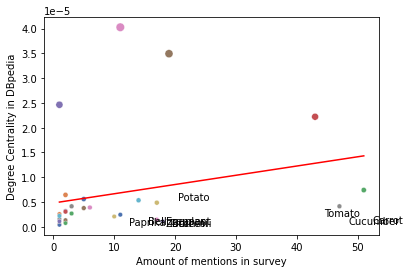

In [286]:
# Regression test for Vegetables

df_vegetables_regression = df_survey_gcm_vegetables.copy()
df_vegetables_regression = df_vegetables_regression.dropna(subset=['pagerank', 'degree']) #drop rows with NaN values

lm_vegs = linear_model.LinearRegression()

dc_array_vegs = df_vegetables_regression['degree'].to_numpy()
dc_array_vegs = dc_array_vegs.reshape(-1, 1)
sv_array_vegs = df_vegetables_regression['amount'].to_numpy()
sv_array_vegs = sv_array_vegs.reshape(-1, 1)

lm_vegs.fit(sv_array_vegs, dc_array_vegs) # fitting the model

print("The coefficient is:", lm_vegs.coef_)
print("The intercept is:",lm_vegs.intercept_)


# Scatter with regression function
sns.scatterplot(data=df_vegetables_regression, x="amount", y="degree", size="degree", legend=False, hue="degree", palette="deep")

#Annotate data points
labels = df_vegetables_regression['name']
# Loop through the data points 
for i, label in enumerate (labels):
    plt.annotate(label, (df_vegetables_regression.amount[i]+1.5, df_vegetables_regression.pagerank[i]))
    if i == 8:
        break
y_pred = lm_vegs.predict(sv_array_vegs)
plt.plot(sv_array_vegs, y_pred, color = "r")

#plt.title('Regression with POTUS and their PageRank', size=18)
plt.xlabel('Amount of mentions in survey')
plt.ylabel('Degree Centrality in DBpedia')

plt.savefig("../plots/plots_vegetables/vegetables_regression_surveyXdc_asc.png", bbox_inches="tight")
plt.show()

### 90s film

In [63]:
%%time

# Merge the DFs based on resource with an Left Merge / Left Outer Join
# (Keep every row in the left dataframe. Missing values get NaN)

# 90s films
film90_result = pd.merge(df_film90,
                 df_gcm[['resource','degree', 'pagerank']],
                 on='resource', 
                 how='left')

#film90_result['resource'] = film90_result.apply(lambda row: node_path(row), axis=1)
film90_result.size

CPU times: user 8.3 s, sys: 1.76 s, total: 10.1 s
Wall time: 11 s


40000

Text(0.5, 1.0, 'Bar plot with films from the 90s and their Degree Centrality')

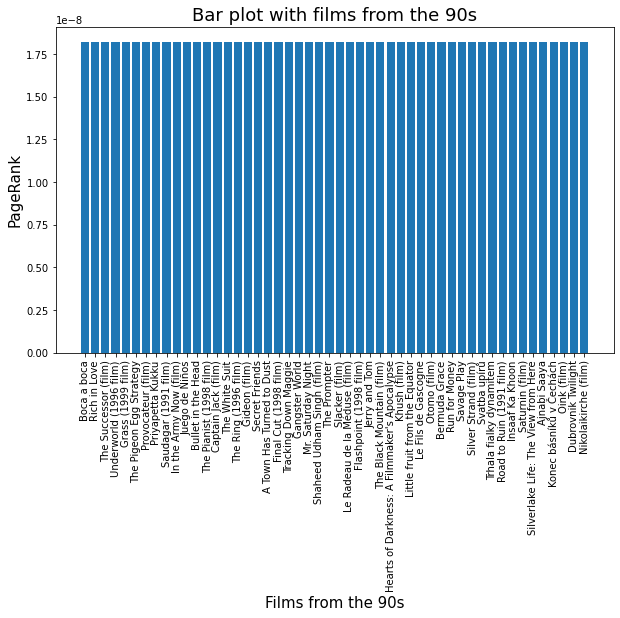

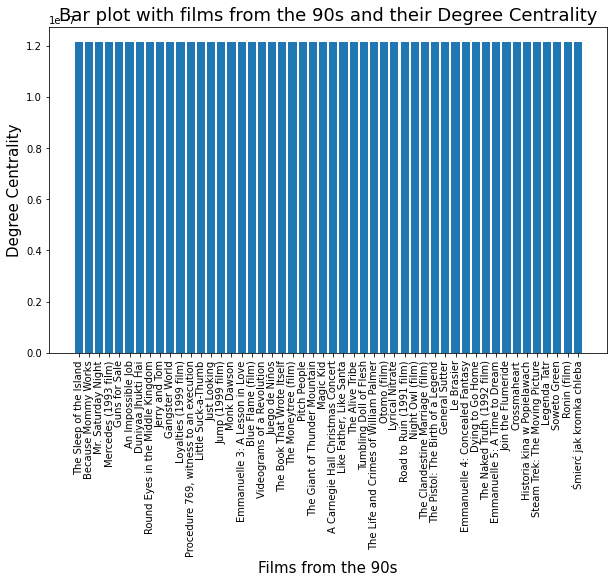

In [64]:
# Barplot PageRank
film90_PR_sorted = film90_result.sort_values('pagerank')
film90_PR_sorted_cut = film90_PR_sorted.head(50)

plt.figure(figsize=(10,6))
plt.bar('name', 'pagerank',data=film90_PR_sorted_cut)
plt.xlabel("Films from the 90s", size=15)
plt.xticks(rotation=90)
plt.ylabel("PageRank", size=15)
plt.title("Bar plot with films from the 90s", size=18)
#plt.savefig("../plots/plots_film90/film90_barplot_PR_asc.png", bbox_inches="tight")

# Barplot Degree Centrality
film90_DC_sorted = film90_result.sort_values('degree')
film90_DC_sorted_cut = film90_DC_sorted.head(50)

plt.figure(figsize=(10,6))
plt.bar('name', 'degree',data=film90_DC_sorted_cut)
plt.xlabel("Films from the 90s", size=15)
plt.xticks(rotation=90)
plt.ylabel("Degree Centrality", size=15)
plt.title("Bar plot with films from the 90s and their Degree Centrality", size=18)
#plt.savefig("../plots/plots_film90/film90_barplot_DC_asc.png", bbox_inches="tight")

In [65]:
film90_PR_sorted_cut.head(10)

,resource,name,degree,pagerank
5629,http://dbpedia.org/resource/Boca_a_boca,Boca a boca,1.213102e-07,1.819668e-08
6105,http://dbpedia.org/resource/Rich_in_Love,Rich in Love,1.213102e-07,1.819668e-08
9633,http://dbpedia.org/resource/The_Successor_(film),The Successor (film),1.213102e-07,1.819668e-08
9193,http://dbpedia.org/resource/Underworld_(1996_f...,Underworld (1996 film),1.213102e-07,1.819668e-08
3057,http://dbpedia.org/resource/Grass_(1999_film),Grass (1999 film),1.213102e-07,1.819668e-08
7735,http://dbpedia.org/resource/The_Pigeon_Egg_Str...,The Pigeon Egg Strategy,1.213102e-07,1.819668e-08
7730,http://dbpedia.org/resource/Provocateur_(film),Provocateur (film),1.213102e-07,1.819668e-08
1540,http://dbpedia.org/resource/Priyapetta_Kukku,Priyapetta Kukku,1.213102e-07,1.819668e-08
6680,http://dbpedia.org/resource/Saudagar_(1991_film),Saudagar (1991 film),1.213102e-07,1.819668e-08
4000,http://dbpedia.org/resource/In_the_Army_Now_(f...,In the Army Now (film),1.213102e-07,1.819668e-08


In [155]:
#TBD: --> nurture survey answers with DBpedia URIs